In [1]:
import os
import tensorflow as tf
import seaborn as sns
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("float32")
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Dense,Activation,Dropout,Conv2D,MaxPooling2D,BatchNormalization,Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
import itertools
import matplotlib.pyplot as plt
import datetime
import matplotlib.image as mping
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [17]:
train_dir="/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/"
val_dir="/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/"
train_data=image_dataset_from_directory(train_dir,batch_size=8,image_size=(224,224),label_mode='categorical',shuffle=True,seed=42)
val_data=image_dataset_from_directory(val_dir,batch_size=8,image_size=(224,224),label_mode='categorical',shuffle=False,seed=42)

Found 70295 files belonging to 38 classes.
Found 17572 files belonging to 38 classes.


In [18]:
class_names=train_data.class_names
class_count=len(class_names)
class_count

38

In [19]:
samples = []
x = 0
for i in tqdm(train_data.unbatch()):
    if (x == 10):
        break
    samples.append([i[0], i[1]])
    x += 1

0it [00:00, ?it/s]

In [20]:
images = []
labels = []
for i in samples:
    images.append(i[0])
    labels.append(class_names[tf.argmax(i[1])])
len(images), len(labels)

(10, 10)

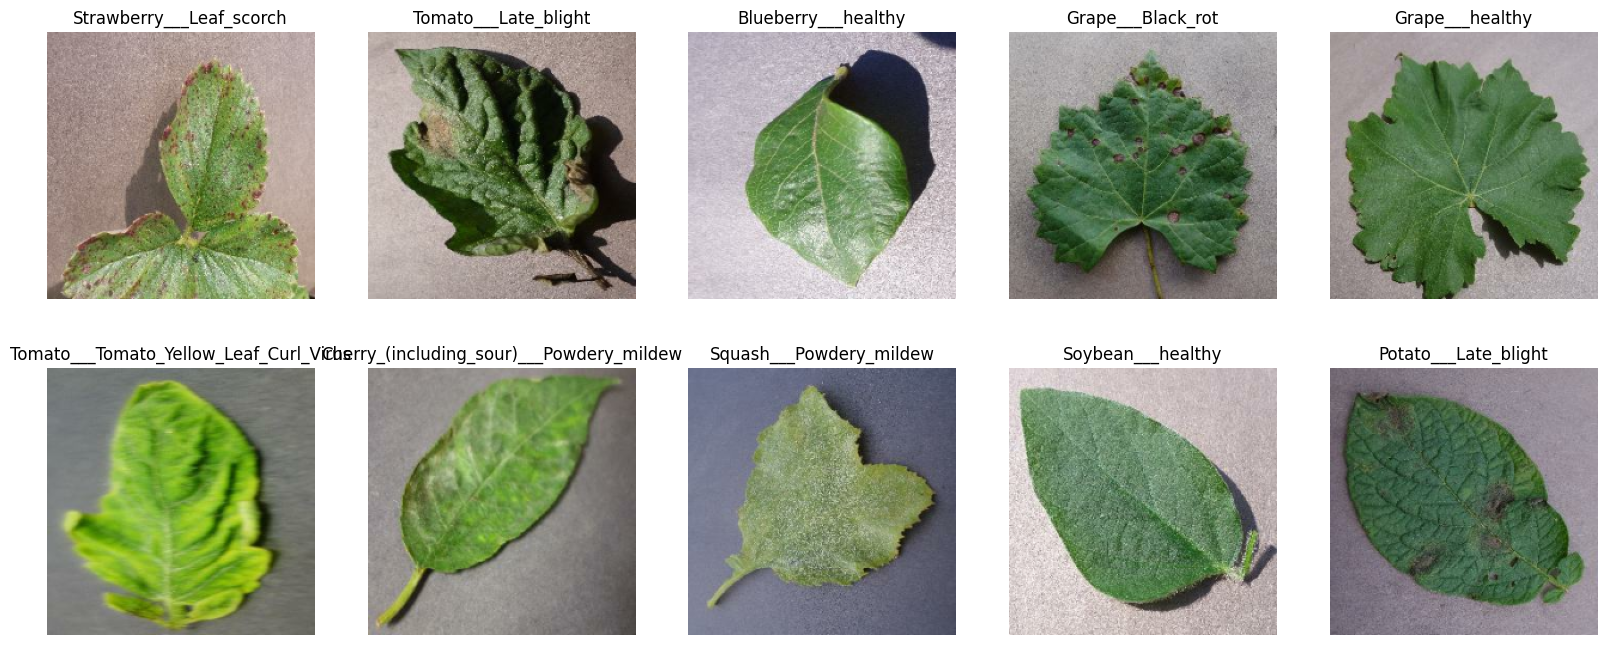

In [21]:
fig = plt.figure(figsize=(20, 8))
rows = 2
cols = 5
x = 1
for image, label in zip(images, labels):
    fig.add_subplot(rows, cols, x)
    plt.imshow(image/255.)
    plt.axis("off")
    plt.title(label)
    x += 1

In [22]:
input_shape = (224, 224, 3)

In [23]:
def create_early_stopper():
    earlystopper = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                    patience=3,
                                                    restore_best_weights=True,
                                                    min_delta=0.001,
                                                    verbose=1)
    return earlystopper

In [24]:
model_name = 'EfficientNetB4'
base_model = tf.keras.applications.EfficientNetB4(
    include_top=False, weights="imagenet", input_shape=(224, 224, 3), pooling='max')

In [25]:
x = base_model.output

x = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.002)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(rate=0.45, seed=42)(x)
output = Dense(class_count, activation='softmax')(x)

model=Model(inputs=base_model.input, outputs=output)
model.compile(tf.keras.optimizers.Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
early_stopper = tf.keras.callbacks.EarlyStopping(patience=5, min_delta=0.01, verbose=1)

In [27]:
history = model.fit(train_data,
                    epochs=60,
                    validation_data=val_data,  
                    callbacks=[early_stopper]
                   )

Epoch 1/60


2024-01-14 10:50:50.342955: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


8787/8787 [==============================] - 1740s 189ms/step - loss: 2.0156 - accuracy: 0.4741 - val_loss: 0.3443 - val_accuracy: 0.9049
Epoch 2/60
8787/8787 [==============================] - 1670s 190ms/step - loss: 0.5189 - accuracy: 0.8512 - val_loss: 0.1366 - val_accuracy: 0.9596
Epoch 3/60
8787/8787 [==============================] - 1669s 190ms/step - loss: 0.2760 - accuracy: 0.9199 - val_loss: 0.0961 - val_accuracy: 0.9746
Epoch 4/60
8787/8787 [==============================] - 1663s 189ms/step - loss: 0.1752 - accuracy: 0.9492 - val_loss: 0.0713 - val_accuracy: 0.9816
Epoch 5/60
8787/8787 [==============================] - 1666s 190ms/step - loss: 0.1240 - accuracy: 0.9641 - val_loss: 0.0649 - val_accuracy: 0.9830
Epoch 6/60
8787/8787 [==============================] - 1664s 189ms/step - loss: 0.0941 - accuracy: 0.9724 - val_loss: 0.0541 - val_accuracy: 0.9868
Epoch 7/60
8787/8787 [==============================] - 1666s 190ms/step - loss: 0.0780 - accuracy: 0.9780 - val_loss